# 再解析データ

再解析データとは，比較的新しい予報モデルに対して過去の観測データを同化したものです。
数値天気予報においては，予報モデルに対して観測を同化した解析値が作成され，初期値として用いられています。
予報モデルは改良が重ねられていくため，解析値の品質はモデルの変遷と共に変化していきます。
データ同化手法も大きく進歩し，数十年前とは全く異なる手法が用いられています。
モデルやデータ同化手法の改良の影響を取り除くことにより，時間的により品質が安定したデータセットになります。
再解析とは，現業予報で一度行った解析を再びやり直すということを意味しています。

:::{caution}
衛星データは世代間のセンサの品質の差やセンサの経年劣化が考慮されていますが，解析値は入力される観測データの種類や量にも影響を受けます。
品質を一貫させるため，大きな精度向上をもたらす衛星データを使わず従来型観測のみを同化したデータセット（JRA-55C{cite}`Kobayashi-etal:2014`，ERA-20C {cite}`Poli-etal:2016`，20CRv3{cite}`Slivinski-etal:2021`）
が作られています。
:::

本書ではサイズが小さく入手が容易なNCEP/NCAR再解析{cite}`Kalnay-etal:1996`を用います。
NCEP/NCAR再解析は，京都大学生存圏研究所[グローバル大気観測データ](http://database.rish.kyoto-u.ac.jp/arch/glob-atmos/)や米国国立大気研究センター（NCAR）[研究データアーカイブ](https://rda.ucar.edu/)等から入手可能です。

:::{note}
より新しい再解析データセットとして3つあげておきます。

- JRA-55{cite}`Kobayashi-etal:2015`: 気象庁が作成した長期再解析。より長期のデータセット作成中でJRA-3Qが近日完了予定。
- MERRA-2{cite}`Gelaro-etal:2017`: NASAによる衛星データを駆使した再解析
- ERA-5{cite}`Hersbach-etal:2020`: 精度に定評があるECMWFが作成したデータセット。積雪深が過大{cite}`Orsolini-etal:2019`
:::

```ipython
!curl -O http://database.rish.kyoto-u.ac.jp/arch/ncep/data/ncep.reanalysis.derived/surface/slp.mon.mean.nc
```

NCEP/NCAR再解析データはNetCDF形式で提供されています。
NetCDFはデータと共に座標などのメタデータが一つのファイルの中に保存されています。
xarrayはnetcdf4ライブラリを使ってNetCDFファイルを読み書きすることができます。
データを読むには`xarray.open_dataset()`を用います。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


ds = xr.open_dataset("slp.mon.mean.nc")

`ds`を印字するとメタ情報が表示されます。

In [2]:
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 883)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-07-01
Data variables:
    slp      (time, lat, lon) float32 ...
Attributes:
    description:    Data is from NMC initialized reanalysis\n(4x/day).  These...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 18:12:35 2000: ncrcat -d time,0,622 /Datasets/...
    title:          monthly mean slp from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

`.sel()`メソッドを用いると配列の添え字ではなく座標値を用いた選択ができます。
東経135度，北緯35度における8月の海面気圧の年々変動を調べてみましょう。
添え字は0から始まるので`[7::12]`となっていることに注意してください。

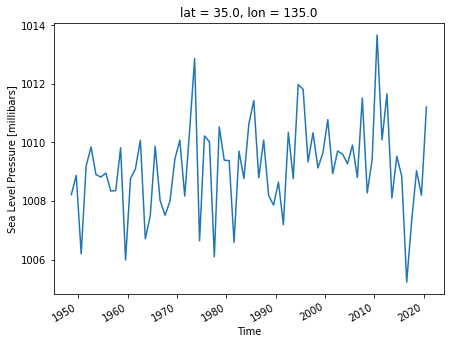

In [3]:
ds.slp.sel(lon=135, lat=35)[7::12].plot(figsize=[7,5])
plt.show()

## Cartopy

海面気圧を正射図法で描いてみます。
正射図法を用いると宇宙から見た地球や地球儀のように描かれます。
[地図投影](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)には[Cartopy](https://scitools.org.uk/cartopy)を用います。
CartopyはPython以外で書かれた外部ライブラリに依存しています。
自分のパソコンを使っている場合は，[インストール方法](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing)や[付録](install)を参考にしてください。
Google Colaboratoryの場合は`!`を使ってシェルを呼び出し，`apt-get`と`pip`を使って依存ライブラリとCartopyをインストールします。

In [ ]:
!apt-get install -qq libgdal-dev libproj-dev
!pip install cartopy

:::{caution}
Google Colaboratoryで以下のようなエラーが出る場合は[shapely](https://github.com/Toblerity/Shapely)のバージョンがcartopyと整合していません。一旦shapelyをアンインストールしてソースからコンパイルします。

```
Geometry must be a Point or LineString
```
:::

In [ ]:
!pip uninstall --yes shapely
!pip install shapely --no-binary shapely
!pip install cartopy

- 1行目: 地図投影が定義されている`cartopy.crs`を`ccrs`という名前でインポートします。
- 5行目: 全球データを描画するとグリニッジ子午線や日付変更線で切れてしまうことがあります。`cartopy.util.add_cyclic_point`を利用して経度方向が周期的になるように点を追加します。
- 8行目: 投影を`projection`に指定します。
`ccrs.Orthographic()`は正射図法で衛星から地球を眺めたような投影法です。
- 10行目: 周期的になるように点を追加した経度，緯度，データを与えて陰影付等値線を`contourf()`で描きます。
`projection`は用いる地図投影を指定するのに対し，描画関数に与える`transform`は，データが定義されている[座標系を指定](https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html)します。
地図投影は正射図法ですが，座標を経度緯度で与えているので`transform`は`PlateCarree()`とします。
`ccrs.PlateCarree()`は標準緯度を赤道とした正距円筒図法で，経度と緯度をそのまま使います。
- 11行目: 海岸線を描きます。
- 12行目: 描画範囲を全球とします。
- 13行目: カラーバーを描きます。

::: {caution} Cartopyは初めて必要となったときに海岸線等のデータをダウンロードします。サーバがダウンしているとデータが取得できないことがあります。
`coastlines()`はNatural Earthのshapefileを簡単に描くためのメソッドです。
CartopyはNatural Earth以外のデータを取得して描くことができます。
`coastlines()`がうまくいかないときは，その代わりに[GSHHS](https://www.ngdc.noaa.gov/mgg/shorelines/gshhs.html)のデータを使ってみましょう。
地図に描く部品をCartopyでは`feature`と呼んでいます。
`GSHHSFeature()`を`add_feature()`メソッドで追加することにより海岸線を描きます。

```python
import cartopy.feature as cfeature

ax.add_feature(cfeature.GSHHSFeature())
```
:::

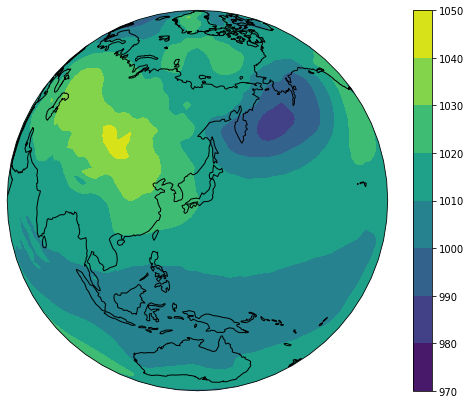

In [10]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point


wdata, wlon = add_cyclic_point(ds.slp.sel(time="2020-12")[0], ds.lon)

fig = plt.figure(figsize=[9, 7])
ax = fig.add_subplot(111, projection=ccrs.Orthographic(135,35))

p = ax.contourf(wlon, ds.lat, wdata, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
fig.colorbar(p)
plt.show()

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


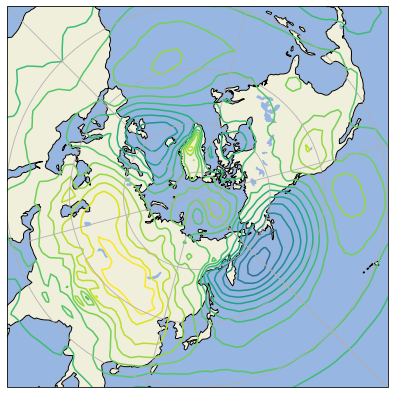

In [14]:
import cartopy.feature as cfeature


fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo(135))

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.LAND)
clevs = np.arange(960, 1040, 4)
p = ax.contour(wlon, ds.lat, slp, levels=clevs, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([0, 359, 20, 90], ccrs.PlateCarree())
ax.gridlines()
plt.show()

細かなパラメタを指定せずに簡単に使えように，NaturalEarthの陸`LAND`，海`OCEAN`，湖水`LAKES`等が定義されています。

- 5行目: `ccrs.LambertConformal()`はランベルト図法を投影に指定します。中心となる経度と緯度を与えます。
- 7～9行目: NaturalEarthの海，湖水，陸のデータを利用します。初回はデータをダウンロードするので，メッセージが表示されます。
- 12行目: 等値線を指定するために4 hPa間隔で960から1036 hPaまでの配列を作り`levels`に与えます。等値線の色は黒にします。
- 14行目: `ax.clabel()`メソッドを呼び，等値線ラベルを自動生成（`manual=False`）し，等値線上に配置（`inline=True`）します。

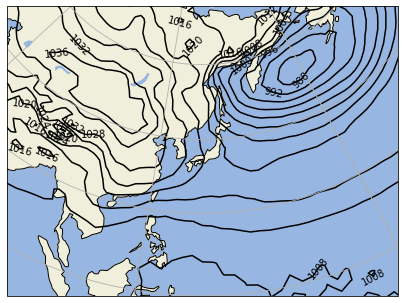

In [15]:
import cartopy.feature as cfeature


fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=ccrs.LambertConformal(135,35))

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.LAND)
ax.coastlines()
p = ax.contour(wlon, ds.lat, slp,
               levels=np.arange(960, 1040, 4), colors=["k"],
               transform=ccrs.PlateCarree())
ax.clabel(p, manual=False, inline=True)
ax.set_extent([90, 180, 0, 70], ccrs.PlateCarree())
ax.gridlines()
plt.show()

大陸上のシベリア高気圧とアリューシャン低気圧がコントラストが明瞭です。